In [1]:
!nvidia-smi

Wed Feb 20 10:09:13 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:01:00.0 Off |                  N/A |
| 45%   72C    P2   208W / 250W |  11629MiB / 12195MiB |     64%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [59]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [75]:
# import numpy as np 
# import os
# import numpy as np
# from keras.models import *
# from keras.layers import *
# from keras.optimizers import *
# from keras.callbacks import ModelCheckpoint, LearningRateScheduler
# from keras import backend as keras

# keras.set_image_data_format('channels_last')

# def unet(pretrained_weights = None,input_size = (1400,1200,1)):
#     inputs = Input(input_size)
#     conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
#     conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
#     conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
#     conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
#     conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
#     conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
#     conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
#     conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
#     drop4 = Dropout(0.5)(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

#     conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
#     conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
#     drop5 = Dropout(0.5)(conv5)

#     up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
#     merge6 = concatenate([drop4,up6], axis = 3)
#     conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
#     conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

#     up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
#     merge7 = concatenate([conv3,up7], axis = 3)
#     conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
#     conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

#     up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
#     merge8 = concatenate([conv2,up8], axis = 3)
#     conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
#     conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

#     up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
#     merge9 = concatenate([conv1,up9], axis = 3)
#     conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
#     conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
#     conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
#     conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

#     model = Model(input = inputs, output = conv10)

#     model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
#     model.summary()

#     if(pretrained_weights):
#     	model.load_weights(pretrained_weights)

#     return model


In [2]:
IMG_WIDTH = 1400
IMG_HEIGHT = 1400

In [3]:
import numpy as np
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam,RMSprop
from keras.callbacks import ModelCheckpoint
from keras import backend as K

K.set_image_data_format('channels_last')  # TF dimension ordering in this code


smooth = 1.


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def get_unet(img_rows = IMG_HEIGHT, img_cols = IMG_WIDTH):
    """"""
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1_1')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1_2')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), name='pool1')(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2_1')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2_2')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), name='pool2')(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3_1')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3_2')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), name='pool3')(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv4_1')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv4_2')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), name='pool4')(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_1')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_2')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (3, 3), strides=(2, 2), name='convT_5')(conv5), conv4], 
                      axis=-1, name='up_convT5_conv4')
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv6_1')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv6_2')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name='convT_6')(conv6), conv3], 
                      axis=-1, name='up_convT6_conv3')
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv7_1')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv7_2')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name='convT_7')(conv7), conv2], 
                      axis=-1, name='up_convT7_conv2')
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv8_1')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv8_2')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', name='convT_8')(conv8), conv1], 
                      axis=-1, name='up_convT8_conv1')
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv9_1')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv9_2')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid', name='conv10_sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
#adam ls=1e-5, RMSprop(lr=2e-4)
    return model

Using TensorFlow backend.


In [4]:
model = get_unet()

In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1400, 1400, 1 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 1400, 1400, 3 320         input_2[0][0]                    
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 1400, 1400, 3 9248        conv1_1[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 700, 700, 32) 0           conv1_2[0][0]                    
__________________________________________________________________________________________________
conv2_1 (C

## Data Preparation

fnames = ["/Users/cdesio/UoB/Jordan/10x10_20mm_v2/File_{}_25mm_mask_*.tiff".format(i) for i in range(100)]

In [5]:
import os

In [6]:
!ls ../data

10x10_10mm_v2_8bit  10x10_25mm_v1   10x10_4mm_v2       10x10_4mm_v2_8bit
10x10_25mm_8bit     10x10_2mm_8bit  10x10_4mm_v2 copy  trained_UNet.hdf5


In [7]:
fnames_orig_2mm = ["../data/10x10_2mm_8bit/{}".format(filename) 
               for filename in sorted(os.listdir("../data/10x10_2mm_8bit/")) 
               if "mask" not in filename and filename.startswith('File')]
fnames_orig_4mm = ["../data/10x10_4mm_v2 copy/{}".format(filename) 
           for filename in sorted(os.listdir("../data/10x10_4mm_v2 copy/")) 
               if "mask" not in filename and filename.startswith('File')]
fnames_orig_10mm = ["../data/10x10_10mm_v2_8bit/{}".format(filename) 
               for filename in sorted(os.listdir("../data/10x10_10mm_v2_8bit/")) 
               if "mask" not in filename and filename.startswith('File')]
fnames_orig_25mm = ["../data/10x10_25mm_8bit/{}".format(filename) 
               for filename in sorted(os.listdir("../data/10x10_25mm_8bit/")) 
               if "mask" not in filename and filename.startswith('File')]

In [8]:
fnames_mask_2mm = ["../data/10x10_2mm_8bit/{}".format(filename) 
               for filename in sorted(os.listdir("../data/10x10_2mm_8bit/")) 
               if "mask" in filename and filename.startswith('File')]
fnames_mask_4mm = ["../data/10x10_4mm_v2 copy/{}".format(filename) 
               for filename in sorted(os.listdir("../data/10x10_4mm_v2 copy/")) 
               if "mask" in filename and filename.startswith('File')]
fnames_mask_10mm = ["../data/10x10_10mm_v2_8bit/{}".format(filename) 
               for filename in sorted(os.listdir("../data/10x10_10mm_v2_8bit/")) 
               if "mask" in filename and filename.startswith('File')]
fnames_mask_25mm = ["../data/10x10_25mm_8bit/{}".format(filename) 
               for filename in sorted(os.listdir("../data/10x10_25mm_8bit/")) 
               if "mask" in filename and filename.startswith('File')]

In [9]:
print(len(fnames_mask_2mm), len(fnames_mask_4mm), len(fnames_mask_10mm), len(fnames_mask_25mm))

300 300 300 300


In [10]:
print(len(fnames_orig_2mm), len(fnames_orig_4mm), len(fnames_orig_10mm), len(fnames_orig_25mm))

300 300 300 300


fnames_mask_train = fnames_mask[:100]
fnames_orig_train = fnames_orig[:100]

In [11]:
fnames_mask = np.hstack((fnames_mask_2mm,fnames_mask_4mm, fnames_mask_10mm, fnames_mask_25mm))

In [12]:
fnames_orig = np.hstack((fnames_orig_2mm,fnames_orig_4mm, fnames_orig_10mm, fnames_orig_25mm))

In [13]:
print(len(fnames_mask), len(fnames_orig))

1200 1200


In [14]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
from matplotlib.cm import gray
%matplotlib inline

In [15]:
ROW_SLICE = slice(0, 1400)
COL_SLICE = slice(1000, None)

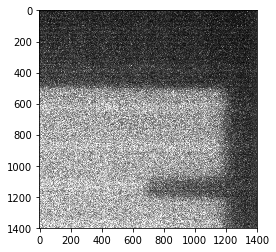

In [14]:
plt.imshow(imread(fnames_orig_train[0])[ROW_SLICE,COL_SLICE],cmap=gray)
plt.show()

In [16]:
X = np.asarray([imread(img)[ROW_SLICE, COL_SLICE] for img in fnames_orig])

In [17]:
y = np.asarray([imread(img)[ROW_SLICE, COL_SLICE] for img in fnames_mask])

In [18]:
print(X.shape, y.shape)

(1200, 1400, 1400) (1200, 1400, 1400)


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [20]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(804, 1400, 1400) (804, 1400, 1400) (396, 1400, 1400) (396, 1400, 1400)


In [21]:
X_train = X_train[..., np.newaxis]

In [22]:
X_train.shape

(804, 1400, 1400, 1)

In [23]:
y_train.shape

(804, 1400, 1400)

In [24]:
y_train = y_train[..., np.newaxis]

In [25]:
y_train.shape

(804, 1400, 1400, 1)

In [29]:
from keras import backend as K
print(K.image_data_format()) # print current format
#K.set_image_data_format('channels_last')

channels_last


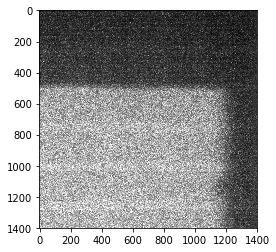

In [132]:
plt.imshow(Xr[0][:, :, 0], cmap=gray)
plt.show()

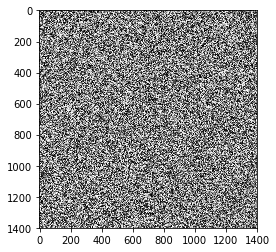

In [29]:
plt.imshow(Xrc[0][:, :, 0], cmap=gray)
plt.show()

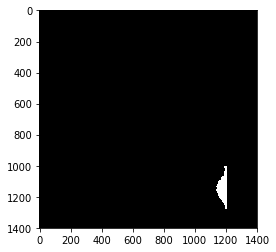

In [133]:
plt.imshow(yr[0][:, :, 0], cmap=gray)
plt.show()

In [134]:
model = get_unet()
model.fit(x=Xr, y=yr, epochs=100, batch_size=2, verbose=1, validation_split=.2)

Train on 960 samples, validate on 240 samples
Epoch 1/100
960/960 [==============================] - 312s 325ms/step - loss: -1.4453 - dice_coef: 1.4453 - val_loss: -1.7268 - val_dice_coef: 1.7268
Epoch 2/100
960/960 [==============================] - 311s 324ms/step - loss: -1.4821 - dice_coef: 1.4821 - val_loss: -1.7974 - val_dice_coef: 1.7974
Epoch 3/100
960/960 [==============================] - 311s 324ms/step - loss: -1.5925 - dice_coef: 1.5925 - val_loss: -1.6746 - val_dice_coef: 1.6746
Epoch 4/100
960/960 [==============================] - 311s 324ms/step - loss: -1.7821 - dice_coef: 1.7821 - val_loss: -1.8480 - val_dice_coef: 1.8480
Epoch 5/100
960/960 [==============================] - 312s 325ms/step - loss: -1.8103 - dice_coef: 1.8103 - val_loss: -1.5350 - val_dice_coef: 1.5350
Epoch 6/100
960/960 [==============================] - 312s 325ms/step - loss: -1.8492 - dice_coef: 1.8492 - val_loss: -1.9425 - val_dice_coef: 1.9425
Epoch 7/100
960/960 [===========================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



960/960 [==============================] - 311s 324ms/step - loss: -1.9387 - dice_coef: 1.9387 - val_loss: -1.9642 - val_dice_coef: 1.9642
Epoch 55/100
960/960 [==============================] - 310s 323ms/step - loss: -1.9398 - dice_coef: 1.9398 - val_loss: -1.9746 - val_dice_coef: 1.9746
Epoch 56/100
960/960 [==============================] - 311s 323ms/step - loss: -1.9440 - dice_coef: 1.9440 - val_loss: -1.9757 - val_dice_coef: 1.9757
Epoch 57/100
960/960 [==============================] - 311s 324ms/step - loss: -1.9436 - dice_coef: 1.9436 - val_loss: -1.9699 - val_dice_coef: 1.9699
Epoch 58/100
960/960 [==============================] - 311s 324ms/step - loss: -1.9445 - dice_coef: 1.9445 - val_loss: -1.9737 - val_dice_coef: 1.9737
Epoch 59/100
960/960 [==============================] - 310s 323ms/step - loss: -1.9406 - dice_coef: 1.9406 - val_loss: -1.9733 - val_dice_coef: 1.9733
Epoch 60/100
960/960 [==============================] - 310s 323ms/step - loss: -1.9435 - dice_coef: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



960/960 [==============================] - 310s 323ms/step - loss: -1.9449 - dice_coef: 1.9449 - val_loss: -1.9715 - val_dice_coef: 1.9715
Epoch 68/100
960/960 [==============================] - 310s 323ms/step - loss: -1.9434 - dice_coef: 1.9434 - val_loss: -1.9573 - val_dice_coef: 1.9573
Epoch 69/100
960/960 [==============================] - 310s 323ms/step - loss: -1.9468 - dice_coef: 1.9468 - val_loss: -1.9756 - val_dice_coef: 1.9756
Epoch 70/100
960/960 [==============================] - 310s 323ms/step - loss: -1.9500 - dice_coef: 1.9500 - val_loss: -1.9712 - val_dice_coef: 1.9712
Epoch 71/100
960/960 [==============================] - 310s 323ms/step - loss: -1.9472 - dice_coef: 1.9472 - val_loss: -1.9677 - val_dice_coef: 1.9677
Epoch 72/100
960/960 [==============================] - 310s 323ms/step - loss: -1.9481 - dice_coef: 1.9481 - val_loss: -1.9726 - val_dice_coef: 1.9726
Epoch 73/100
960/960 [==============================] - 310s 323ms/step - loss: -1.9410 - dice_coef: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



960/960 [==============================] - 310s 323ms/step - loss: -1.9456 - dice_coef: 1.9456 - val_loss: -1.9747 - val_dice_coef: 1.9747
Epoch 81/100
960/960 [==============================] - 310s 323ms/step - loss: -1.9499 - dice_coef: 1.9499 - val_loss: -1.9764 - val_dice_coef: 1.9764
Epoch 82/100
960/960 [==============================] - 310s 323ms/step - loss: -1.9484 - dice_coef: 1.9484 - val_loss: -1.9761 - val_dice_coef: 1.9761
Epoch 83/100
960/960 [==============================] - 310s 323ms/step - loss: -1.9493 - dice_coef: 1.9493 - val_loss: -1.9772 - val_dice_coef: 1.9772
Epoch 84/100
960/960 [==============================] - 309s 322ms/step - loss: -1.9493 - dice_coef: 1.9493 - val_loss: -1.9737 - val_dice_coef: 1.9737
Epoch 85/100
960/960 [==============================] - 310s 322ms/step - loss: -1.9530 - dice_coef: 1.9530 - val_loss: -1.9762 - val_dice_coef: 1.9762
Epoch 86/100
580/960 [=================>............] - ETA: 1:52 - loss: -1.9491 - dice_coef: 1.9491

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



960/960 [==============================] - 309s 322ms/step - loss: -1.9545 - dice_coef: 1.9545 - val_loss: -1.9744 - val_dice_coef: 1.9744
Epoch 94/100
960/960 [==============================] - 309s 322ms/step - loss: -1.9517 - dice_coef: 1.9517 - val_loss: -1.9779 - val_dice_coef: 1.9779
Epoch 95/100
960/960 [==============================] - 309s 322ms/step - loss: -1.9490 - dice_coef: 1.9490 - val_loss: -1.9261 - val_dice_coef: 1.9261
Epoch 96/100
960/960 [==============================] - 309s 322ms/step - loss: -1.9488 - dice_coef: 1.9488 - val_loss: -1.9760 - val_dice_coef: 1.9760
Epoch 97/100
960/960 [==============================] - 309s 322ms/step - loss: -1.9548 - dice_coef: 1.9548 - val_loss: -1.9645 - val_dice_coef: 1.9645
Epoch 98/100
960/960 [==============================] - 309s 322ms/step - loss: -1.9511 - dice_coef: 1.9511 - val_loss: -1.9482 - val_dice_coef: 1.9482
Epoch 99/100
518/960 [===============>..............] - ETA: 2:10 - loss: -1.9532 - dice_coef: 1.9532

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [136]:
model.save("../data/trained_UNet.hdf5")

In [137]:
preds = model.predict(Xr[80:90])

In [139]:
Xr.shape

(1200, 1400, 1400, 1)

In [32]:
X_test.shape

(396, 1400, 1400, 1)

In [29]:
X_test = X_test[..., np.newaxis]

In [32]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [30]:
from keras.models import load_model
model = get_unet()
model.load_weights('../data/trained_UNet.hdf5')

In [47]:
X_test.shape

(396, 1400, 1400, 1)

In [48]:
X_test[20:21].shape

(1, 1400, 1400, 1)

In [49]:
X_test[0].shape

(1400, 1400, 1)

In [54]:
preds = model.predict_on_batch(X_test[0][np.newaxis,...])

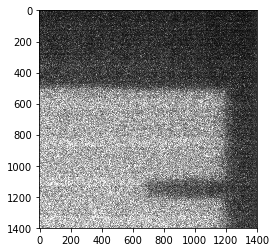

In [26]:
plt.imshow(Xr[80][...,0],cmap='gray')

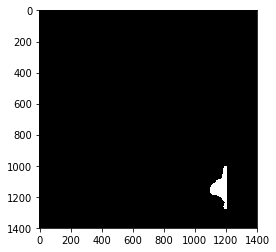

In [42]:
plt.imshow(y_test[20],cmap='gray')

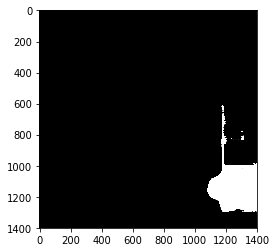

In [35]:
plt.imshow(preds[0][..., 0], cmap=gray)

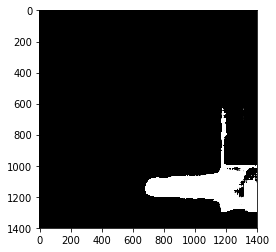

In [56]:
plt.imshow(preds[0][..., 0], cmap=gray)

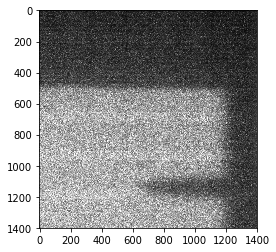

In [53]:
plt.imshow(X_test[0][..., 0], cmap=gray)

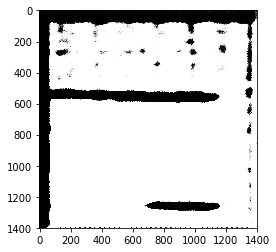

In [68]:
plt.imshow(preds[2][..., 0], cmap=gray)